In [16]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [17]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [18]:
y.shape, tx.shape

((10000,), (10000, 2))

# Computing the Cost Function
Fill in the the `compute_cost` function below:

In [19]:
def compute_loss(y, tx, w, mae = False):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    loss = 0
    N = y.shape[0]
    e = y-np.dot(tx,w)
    
    if not mae:
        loss = 1/(2*N) * (np.dot(np.transpose(e),e))
    else:
        loss = 1/N * np.sum(np.absolute(e))

    return loss


# Grid Search

Fill in the function `grid_search()` below:

In [20]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    for idx, i in enumerate(w0):
        for idx2, j in enumerate(w1):
            losses[idx][idx2] = compute_loss(y, tx, [i,j])
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=15.6100856524888, w0*=73.36683417085428, w1*=12.8140703517588, execution time=2.269 seconds


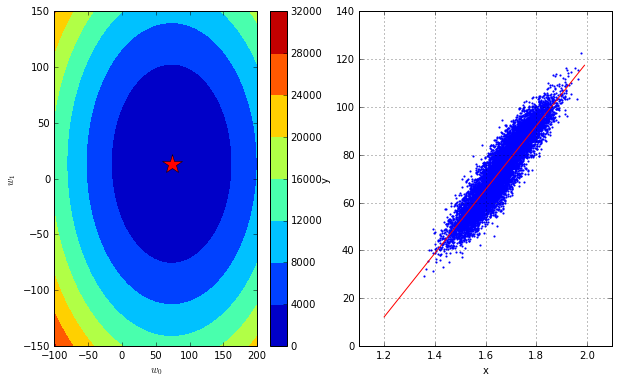

In [21]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization
import datetime

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=200)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [22]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    N = y.shape[0]
    e = y-np.dot(tx,w)
    
    return -1/N * np.dot(np.transpose(tx), e) # sign(e)

Please fill in the functions `gradient_descent` below:

In [23]:
def gradient_descent(y, tx, initial_w, max_iters, gamma): 
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        grad = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        w = w - gamma * grad
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [24]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.9

# Initialization
w_initial = np.array([0.0, 0.0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2792.2367127591665, w0=65.96452980189453, w1=12.131741191490223
Gradient Descent(1/49): loss=43.15439611773371, w0=72.56098278208411, w1=13.344915310639168
Gradient Descent(2/49): loss=15.663572951318455, w0=73.22062808010308, w1=13.46623272255406
Gradient Descent(3/49): loss=15.388664719654292, w0=73.28659260990497, w1=13.47836446374555
Gradient Descent(4/49): loss=15.385915637337646, w0=73.29318906288516, w1=13.479577637864699
Gradient Descent(5/49): loss=15.385888146514484, w0=73.29384870818319, w1=13.479698955276614
Gradient Descent(6/49): loss=15.385887871606256, w0=73.29391467271299, w1=13.479711087017805
Gradient Descent(7/49): loss=15.385887868857171, w0=73.29392126916596, w1=13.479712300191924
Gradient Descent(8/49): loss=15.385887868829677, w0=73.29392192881127, w1=13.479712421509337
Gradient Descent(9/49): loss=15.385887868829402, w0=73.2939219947758, w1=13.479712433641078
Gradient Descent(10/49): loss=15.385887868829398, w0=73.29392200137225, w1

<function __main__.plot_figure>

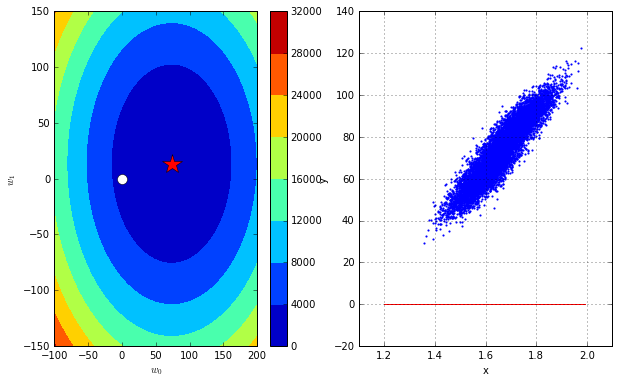

In [25]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

# Stochastic gradient descent

In [26]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient for batch data."""
    N = y.shape[0]
    e = y-np.dot(tx,w)

    return -1/N * np.dot(np.transpose(tx), e)


def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_epochs, gamma):
    losses = []
    ws = [initial_w]
    w = initial_w
    for n_iter in range(max_epochs):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            grad = compute_stoch_gradient(minibatch_y, minibatch_tx, w)
            loss = compute_loss(y, tx, w)
            losses.append(loss)

            w = w - gamma * grad
            ws.append(w)
    return losses, ws

In [27]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.4
batch_size = 4

# Initialization
w_initial = np.array([0.0, 0.0])

# Start SGD.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.048 seconds


<function __main__.plot_figure>

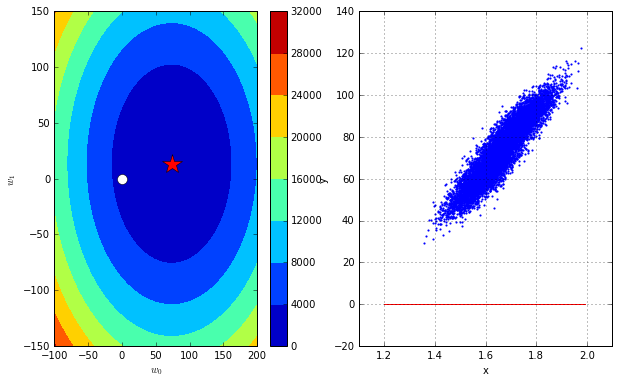

In [28]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))